# Integration with Python

This cookbook explains you how to perform azimuthal integration using the Python interpreter.
It is divided in two parts, the first part uses purely Python while the second uses some advanced features of the Jupyter notebook.

We will re-use the same files as in the other tutorials.

## Performing azimuthal integration with pyFAI of a bunch of images

To be able to perform the azimuthal integration of some images, one needs:

* The diffraction images themselves, in this example they are stored as EDF files
* The geometry of the experimental setup as obtained from the calibration and stored as a PONI-file
* other files like flat-field, dark current images or detector distortion file (spline-file).

Image file: http://www.silx.org/pub/pyFAI/cookbook/calibration/Eiger4M_Al2O3_13.45keV.edf

Geometry file: http://www.silx.org/pub/pyFAI/cookbook/calibration/alpha-Al2O3.poni

The calibration has been performed in the previous cookbook.

### Basic usage of pyFAI
To perform azimuthal averaging, one can use pyFAI to load the geometry and FabIO to read the image:

In [1]:
# This cell is just to download the files to perform the analysis:
import time
import shutil, os
from silx.resources import ExternalResources

t0 = time.perf_counter()

downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/cookbook/calibration/", "PYFAI_DATA")
image_file = downloader.getfile("Eiger4M_Al2O3_13.45keV.edf")
poni_file = downloader.getfile("alpha-Al2O3.poni")

print("image_file:", image_file)
print("poni_file:", poni_file)

# Copy all files locally
shutil.copy(poni_file, ".")
shutil.copy(image_file, ".")
# clean-up files from previous run:
for result in ('integrated.edf', "integrated.dat", "Eiger4M_Al2O3_13.45keV.dat"):
    if os.path.exists(result):
        os.unlink(result)

os.listdir()

image_file: /tmp/pyFAI_testdata_jerome/Eiger4M_Al2O3_13.45keV.edf
poni_file: /tmp/pyFAI_testdata_jerome/alpha-Al2O3.poni


['alpha-Al2O3.poni',
 'F_K4320T_Cam43_30012013_distorsion.spline',
 'integration_with_scripts.ipynb',
 'integration_with_python.ipynb',
 'LaB6_29.4keV.tif',
 'integration_with_the_gui.rst',
 '.ipynb_checkpoints',
 'calib-gui',
 'pyFAI-integrate.png',
 'Eiger4M_Al2O3_13.45keV.edf',
 'LaB6_29.4keV.dat',
 'index.rst',
 'calib-cli',
 'LaB6_29.4keV.poni']

In [2]:
import pyFAI, fabio
print("pyFAI version:", pyFAI.version)
img = fabio.open("Eiger4M_Al2O3_13.45keV.edf")
print("Image:", img)

ai = pyFAI.load("alpha-Al2O3.poni")
print("\nIntegrator: \n", ai)

pyFAI version: 0.20.0-beta1
Image: <fabio.edfimage.EdfImage object at 0x7f142cd72fd0>

Integrator: 
 Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
Wavelength= 9.218156e-11m
SampleDetDist= 1.625467e-01m	PONI= 9.636511e-02, 8.600623e-02m	rot1=0.002605  rot2= 0.000641  rot3= 0.000000 rad
DirectBeamDist= 162.547mm	Center: x=1141.104, y=1286.257 pix	Tilt=0.154 deg  tiltPlanRotation= 166.178 deg


### Azimuthal averaging using pyFAI


One needs first to retrieve the image as a numpy array. This allows to use other libraries than FabIO for image reading, for example HDF5 files.

This shows how to perform the azimuthal integration of one image over 1000 bins:

In [3]:
img_array = img.data
print("img_array:", type(img_array), img_array.shape, img_array.dtype)
mask = img_array>4e9

res = ai.integrate1d_ng(img_array, 
                        1000, 
                        mask=mask,
                        unit="2th_deg", 
                        filename="integrated.dat")

img_array: <class 'numpy.ndarray'> (2167, 2070) float32


*Note:* There are 2 mandatory parameters for this method: the 2D-numpy array with the image and the number of bins. In addition, we specified the name of the file where to save the data and the unit for performing the integration.

There are many other options of `integrate1d`. The difference between the `legacy` and the `ng` flavor is mostly on the way error is propagated:

In [4]:
help(ai.integrate1d_ng)

Help on method integrate1d_ng in module pyFAI.azimuthalIntegrator:

integrate1d_ng(data, npt, filename=None, correctSolidAngle=True, variance=None, error_model=None, radial_range=None, azimuth_range=None, mask=None, dummy=None, delta_dummy=None, polarization_factor=None, dark=None, flat=None, method='csr', unit=q_nm^-1, safe=True, normalization_factor=1.0, metadata=None) method of pyFAI.azimuthalIntegrator.AzimuthalIntegrator instance
    Calculate the azimuthal integration (1d) of a 2D image.
    
    Multi algorithm implementation (tries to be bullet proof), suitable for SAXS, WAXS, ... and much more
    Takes extra care of normalization and performs proper variance propagation.
    
    :param ndarray data: 2D array from the Detector/CCD camera
    :param int npt: number of points in the output pattern
    :param str filename: output filename in 2/3 column ascii format
    :param bool correctSolidAngle: correct for solid angle of each pixel if True 
    :param ndarray variance: arra

The result file contains the integrated data with some headers as shown:

In [5]:
with open("integrated.dat") as f:
    for i in range(50):
        print(f.readline().strip())

# == pyFAI calibration ==
# Distance Sample to Detector: 0.16254673947902704 m
# PONI: 9.637e-02, 8.601e-02 m
# Rotations: 0.002605 0.000641 0.000000 rad
#
# == Fit2d calibration ==
# Distance Sample-beamCenter: 162.547 mm
# Center: x=1141.104, y=1286.257 pix
# Tilt: 0.154 deg  TiltPlanRot: 166.178 deg
#
# Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
#    Detector has a mask: True
#    Detector has a dark current: False
#    detector has a flat field: False
#
# Wavelength: 9.218156017338309e-11 m
# Mask applied: user provided
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> integrated.dat
#       2th_deg             I
1.919453e-02    1.069850e+02
5.758360e-02    1.369700e+02
9.597267e-02    1.055188e+03
1.343617e-01    7.239056e+03
1.727508e-01    0.000000e+00
2.111399e-01    2.046833e+04
2.495289e-01    1.767070e+04
2.879180e-01    1.170921e+04
3.263071e-01    7.144741e+03
3.646961e-01    4.495773e+03
4.030

### Azimuthal regrouping using pyFAI

This option is similar to the integration but performs N integrations on various azimuthal angle (chi) sections of the space. It is also named "caking" in Fit2D.

The azimuthal regrouping of an image over 500 radial bins in 360 angular steps (of 1 degree) can be performed like this:


In [6]:
res2 = ai.integrate2d_ng(img_array, 
                         500, 360, 
                         unit="r_mm", 
                         filename="integrated.edf")

In [7]:
cake = fabio.open("integrated.edf")
print(cake.header)
print("cake:", type(cake.data), cake.data.shape, cake.data.dtype)


{
  "EDF_DataBlockID": "0.Image.Psd",
  "EDF_BinarySize": "720000",
  "EDF_HeaderSize": "1536",
  "ByteOrder": "LowByteFirst",
  "DataType": "FloatValue",
  "Dim_1": "500",
  "Dim_2": "360",
  "Image": "0",
  "HeaderID": "EH:000000:000000:000000",
  "Size": "720000",
  "Engine": "Detector Eiger 4M PixelSize= 7.500e-05, 7.500e-05 m Wavelength= 9.218156e-11m SampleDetDist= 1.625467e-01m PONI= 9.636511e-02, 8.600623e-02m rot1=0.002605 rot2= 0.000641 rot3= 0.000000 rad DirectBeamDist= 162.547mm Center: x=1141.104, y=1286.257 pix Tilt=0.154 deg tiltPlanRotation= 166.178 deg",
  "detector": "Eiger 4M",
  "pixel1": "7.5e-05",
  "pixel2": "7.5e-05",
  "max_shape": "(2167, 2070)",
  "dist": "0.16254673947902704",
  "poni1": "0.09636511239091199",
  "poni2": "0.08600622810318177",
  "rot1": "0.0026048269580961157",
  "rot2": "0.0006408875619633374",
  "rot3": "7.381054962294179e-11",
  "wavelength": "9.218156017338309e-11",
  "r_mm_min": "0.1289601535655313",
  "r_mm_max": "128.83119341196578",


From this, it is trivial to perform a loop and integrate many images. 

*Attention:* The AzimuthalIntegrator object (called `ai` here) is rather large and costly to initialize. The best practice is to create it once and to use it many times, like this:

In [8]:
import glob, os

all_images = glob.glob("Eiger4M_*.edf")
ai = pyFAI.load("alpha-Al2O3.poni")

for one_image in all_images:
    fimg = fabio.open(one_image)
    dest = os.path.splitext(one_image)[0] + ".dat"
    ai.integrate1d_ng(fimg.data, 
                   1000, 
                   unit="2th_deg", 
                   filename=dest)

## Using some advanced features of Jupyter Notebooks

Jupyter notebooks offer some advanced visualization features, especially when used with *matplotlib* and *pyFAI*.
Unfortunately, the example shown hereafter will not work properly in normal Python scipts.

### Initialization of the notebook for matplotlib integration:


In [9]:
from pyFAI.gui import jupyter

### Visualization of different types of results previously calculated

<AxesSubplot:title={'center':'Eiger4M_Al2O3_13.45keV.edf'}>

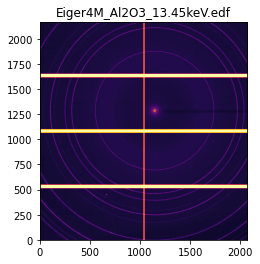

In [10]:
jupyter.display(img.data, label=img.filename)

<AxesSubplot:title={'center':'1D integration'}, xlabel='Scattering angle $2\\theta$ ($^{o}$)', ylabel='Intensity'>

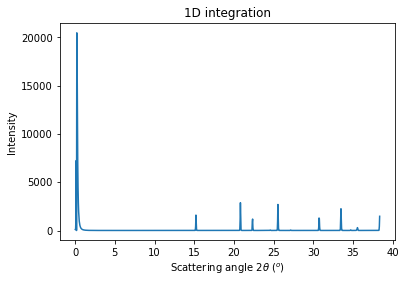

In [11]:
jupyter.plot1d(res)

<AxesSubplot:xlabel='Radius $r$ ($mm$)', ylabel='Azimuthal angle $\\chi$ ($^{o}$)'>

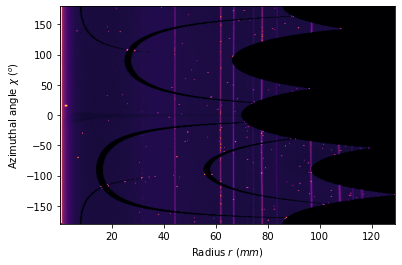

In [12]:
jupyter.plot2d(res2)

## Conclusion

This cookbook explains the basic usage of pyFAI as a Python library for azimuthal integration and simple visualization in the Jupyter notebook.

In [13]:
print(f"Total execution time: {time.perf_counter() - t0 :6.3f} s")

Total execution time:  4.419 s
